<a href="https://colab.research.google.com/github/yoheikikuta/PyTorch-check/blob/master/notebooks/adversarial_sticker_in_digital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torchvision.models as models

In [0]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 28.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/1200px-STOP_sign.jpg -O ./test.jpg
# !wget https://upload.wikimedia.org/wikipedia/commons/7/7f/Egyptian_Mau_Bronze.jpg -O ./test.jpg

--2019-11-30 03:30:19--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/1200px-STOP_sign.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397355 (388K) [image/jpeg]
Saving to: ‘./test.jpg’

./test.jpg          100%[===================>] 388.04K  --.-KB/s    in 0.06s   

2019-11-30 03:30:19 (6.65 MB/s) - ‘./test.jpg’ saved [397355/397355]



In [0]:
from skimage import io

In [0]:
img_array = io.imread("./test.jpg")

In [5]:
img_array.shape

(1296, 1200, 3)

In [0]:
import matplotlib.pyplot as plt

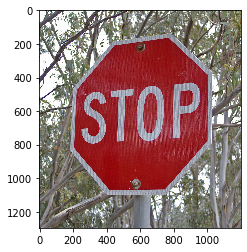

In [7]:
plt.figure()
plt.imshow(img_array)
plt.show()

In [0]:
from torchvision import transforms, utils

composed = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [0]:
import PIL

In [0]:
transformed_img = composed(PIL.Image.fromarray(img_array))

In [11]:
transformed_img.shape

torch.Size([3, 256, 256])

In [0]:
import copy

def plot_img_from_normalized_img(img_array, is_normalized=True):
    img_to_be_plotted = copy.deepcopy(img_array)
    assert len(img_array.shape) == 3
    if img_to_be_plotted.shape[0] == 3:
        img_to_be_plotted = img_to_be_plotted.transpose(1, 2, 0)
    if is_normalized:
        for idx, (m, v) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
            img_to_be_plotted[:, :, idx] = (img_to_be_plotted[:, :, idx] * v) + m
    plt.figure()
    plt.imshow(img_to_be_plotted)
    plt.show()

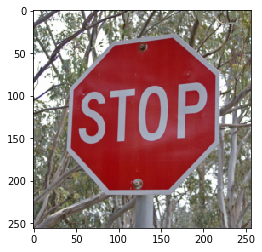

In [13]:
plot_img_from_normalized_img(transformed_img.detach().numpy())

In [0]:
transformed_img.unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [0]:
pred = resnet50(transformed_img.unsqueeze(0))

NameError: ignored

In [0]:
pred.shape

NameError: ignored

In [14]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json 

--2019-11-30 03:30:44--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.184.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.184.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.01s   

2019-11-30 03:30:44 (2.66 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [0]:
import json

with open("./imagenet_class_index.json") as json_file:
    class_idx = json.load(json_file)

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [0]:
import numpy as np

In [0]:
idx2label[np.argmax(pred.detach().numpy())]

'street_sign'

In [0]:
for elem in np.argsort(pred.detach().numpy())[0][-5:]:
    print(idx2label[elem])

mailbox
barn
traffic_light
water_tower
street_sign


## Construct attaking method

In [0]:
block_size = (255 - 30) // 5

position_caididates = []
for y_idx in range(1, 6):
    for x_idx in range(1, 6):
        x_pos = x_idx * 5 + (x_idx - 1) * block_size + block_size // 2
        y_pos = y_idx * 5 + (y_idx - 1) * block_size + block_size // 2
        position_caididates.append((x_pos, y_pos))
        # print(x_pos, y_pos)

In [0]:
def circleMask(width, height, alpha_max=1., r=50., beta=2., center=None):
    assert center != None
    assert alpha_max <= 1.
    x = np.arange(0, width, 1, float)
    y = np.arange(0, height, 1, float)
    x, y = np.meshgrid(x,y)
 
    x0, y0 = center
    d = ((x - x0) ** 2 + (y - y0) ** 2) / r ** 2

    return np.exp(- d ** beta + 1e-10)

In [0]:
circleMask(256, 256, center=(128, 128)).shape

(256, 256)

In [0]:
mask = circleMask(256, 256, center=position_caididates[0])
alpha = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

In [0]:
color = np.zeros_like(alpha)
# color[:, :, 2] = 1.0  # Blue color
color[:, :, 2] = 255  # Blue color

In [0]:
test = np.array(PIL.Image.fromarray(img_array).resize((256, 256)))
# test = test / 255.

In [0]:
blended = (1 - alpha) * test + alpha * color
blended = blended.astype(np.uint8)

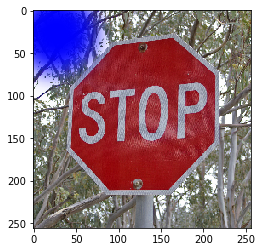

In [0]:
plt.figure()
plt.imshow(blended)
plt.show()

In [0]:
transformed_img = composed(PIL.Image.fromarray(blended))

In [0]:
pred = resnet50(transformed_img.unsqueeze(0))
for elem in np.argsort(pred.detach().numpy())[0][-5:]:
    print(idx2label[elem])

mailbox
birdhouse
chainlink_fence
barn
street_sign


In [0]:
import torch.nn.functional as F

In [0]:
import torch

In [0]:
true_label_idx = 919
target_label_idx = 402

idx2label[true_label_idx], idx2label[target_label_idx]

('street_sign', 'acoustic_guitar')

In [0]:
F.nll_loss(pred, torch.tensor([true_label_idx])), F.nll_loss(pred, torch.tensor([target_label_idx]))

(tensor(-11.3393, grad_fn=<NllLossBackward>),
 tensor(0.7896, grad_fn=<NllLossBackward>))

In [0]:
def create_blended_img(img, pos):
    mask = circleMask(256, 256, center=pos)
    alpha = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    color = np.zeros_like(alpha)
    color[:, :, 2] = 255  # Blue color
    base = np.array(PIL.Image.fromarray(img).resize((256, 256)))

    blended = (1 - alpha) * base + alpha * color
    blended = blended.astype(np.uint8)

    return blended

In [0]:
def predict(model, img):
    transformed_img = composed(PIL.Image.fromarray(img))
    pred = model(transformed_img.unsqueeze(0))
    return pred

In [0]:
def compute_loss(pred, true_idx, target_idx):
    true_label_contrib = F.nll_loss(pred, torch.tensor([true_label_idx]))
    target_label_contrib = F.nll_loss(pred, torch.tensor([target_label_idx]))
    return true_label_contrib, target_label_contrib

In [0]:
for pos in position_caididates:
    blended_img = create_blended_img(img_array, pos)
    pred = predict(resnet50, blended_img)
    tr, ta = compute_loss(pred, true_label_idx, target_label_idx)
    print(pos, tr, ta)

(27, 27) tensor(-11.3393, grad_fn=<NllLossBackward>) tensor(0.7896, grad_fn=<NllLossBackward>)
(77, 27) tensor(-11.0002, grad_fn=<NllLossBackward>) tensor(0.8998, grad_fn=<NllLossBackward>)
(127, 27) tensor(-10.6130, grad_fn=<NllLossBackward>) tensor(0.7640, grad_fn=<NllLossBackward>)
(177, 27) tensor(-10.9633, grad_fn=<NllLossBackward>) tensor(0.2523, grad_fn=<NllLossBackward>)
(227, 27) tensor(-11.0156, grad_fn=<NllLossBackward>) tensor(0.7294, grad_fn=<NllLossBackward>)
(27, 77) tensor(-10.4847, grad_fn=<NllLossBackward>) tensor(0.4490, grad_fn=<NllLossBackward>)
(77, 77) tensor(-10.7788, grad_fn=<NllLossBackward>) tensor(0.4315, grad_fn=<NllLossBackward>)
(127, 77) tensor(-12.8186, grad_fn=<NllLossBackward>) tensor(0.9240, grad_fn=<NllLossBackward>)
(177, 77) tensor(-10.6828, grad_fn=<NllLossBackward>) tensor(-0.0904, grad_fn=<NllLossBackward>)
(227, 77) tensor(-10.5072, grad_fn=<NllLossBackward>) tensor(0.3061, grad_fn=<NllLossBackward>)
(27, 127) tensor(-10.8411, grad_fn=<NllLoss

## Define various classes

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [0]:
# def circleMask(width, height, alpha_max=1., r=50., beta=2., center=None):
#     assert center != None
#     assert alpha_max <= 1.
#     x = np.arange(0, width, 1, float)
#     y = np.arange(0, height, 1, float)
#     x, y = np.meshgrid(x,y)
 
#     x0, y0 = center
#     d = ((x - x0) ** 2 + (y - y0) ** 2) / r ** 2

#     return np.exp(- d ** beta + 1e-10)

In [0]:
# def create_blended_img(img, pos):
#     mask = circleMask(256, 256, center=pos)
#     alpha = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
#     color = np.zeros_like(alpha)
#     color[:, :, 2] = 255  # Blue color
#     base = np.array(PIL.Image.fromarray(img).resize((256, 256)))

#     blended = (1 - alpha) * base + alpha * color
#     blended = blended.astype(np.uint8)

#     return blended

In [0]:
class ImageDot(nn.Module):
    def __init__(self):
        super(ImageDot, self).__init__()
        self.means = [0.485, 0.456, 0.406]
        self.stds = [0.229, 0.224, 0.225]
        self.alpha = 0.5
        # self.alpha = nn.Parameter(torch.tensor(0.5), requires_grad=True)
        self.radius = 25.0
        self.beta = 2.0
        self.center = nn.Parameter(torch.tensor([
            [0.25, 0.25], [0.25, 0.5], [0.25, 0.75],
            [0.5, 0.25], [0.5, 0.5], [0.5, 0.75],
            [0.75, 0.25], [0.75, 0.5], [0.75, 0.75]]),
            requires_grad=True)
        # self.center = nn.Parameter(torch.tensor([127., 127.]), requires_grad=True)
        self.color = nn.Parameter(torch.tensor([
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
            requires_grad=True)
        # self.center = (100, 200)
        # self.color = (0., 0., 1.)
    
    def forward(self, x):
        _, _, height, width = x.shape
        blended = x
        for idx in range(self.center.shape[0]):
            mask = self._create_circle_mask(height, width, self.center[idx] * 255.0, self.beta)
            normalized_color = self._normalize_color(self.color[idx], self.means, self.stds)
            blended = self._create_blended_img(blended, mask, normalized_color)
        # mask = self._create_circle_mask(height, width, self.center * 255.0, self.beta)
        # normalized_color = self._normalize_color(self.color, self.means, self.stds)
        # blended = self._create_blended_img(x, mask, normalized_color)
        return blended
 
    def _normalize_color(self, color, means, stds):
        return list(map(lambda x, m, s: (x - m) / s, color, means, stds))

    def _create_circle_mask(self, height, width, center, beta):
        hv, wv = torch.meshgrid([torch.arange(0, height), torch.arange(0, width)])
        d = ((hv - center[0]) ** 2 + (wv - center[1]) ** 2) / self.radius ** 2
        return torch.exp(- d ** beta + 1e-10)

    def _create_blended_img(self, base, mask, color):
        alpha_tile = mask.expand(3, mask.shape[0], mask.shape[1])
        color_tile = torch.zeros_like(base)
        for c in range(3):
            color_tile[:, c, :, :] = color[c]
        # return (1. - self.alpha) * (1. - alpha_tile) * base + self.alpha * alpha_tile * color_tile
        return (1. - alpha_tile) * base + self.alpha * alpha_tile * color_tile


class AttackModel(nn.Module):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.image_dot = ImageDot()
        self.base_model = models.resnet50(pretrained=True).eval()     
        self._freeze_pretrained()

    def _freeze_pretrained(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.image_dot(x)
        return self.base_model(x)

In [0]:
from torchvision import transforms, utils

composed = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [0]:
test = ImageDot()

In [0]:
from skimage import io
img_array = io.imread("./test.jpg")

In [0]:
transformed_img = composed(PIL.Image.fromarray(img_array))

In [0]:
a = test(transformed_img.unsqueeze(0))

In [91]:
a.shape

torch.Size([1, 3, 256, 256])

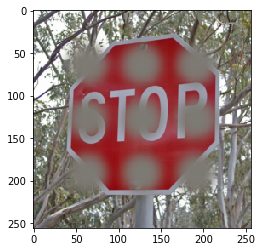

In [92]:
plot_img_from_normalized_img(a.squeeze().detach().numpy())

In [93]:
for elem in test.parameters():
    print(elem)

Parameter containing:
tensor([[0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500]], requires_grad=True)
Parameter containing:
tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]], requires_grad=True)


In [0]:
result = a.mean()
grad_check = result.backward(retain_graph=True)

In [95]:
result

tensor(0.1136, grad_fn=<MeanBackward0>)

In [96]:
for elem in test.parameters():
    print(elem, elem.grad)

Parameter containing:
tensor([[0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500]], requires_grad=True) tensor([[ 0.2108,  0.1401],
        [-0.0097,  0.0175],
        [ 0.0298, -0.1390],
        [ 0.0028,  0.0473],
        [-0.0113, -0.0433],
        [ 0.0681,  0.0195],
        [-0.0659,  0.0836],
        [-0.1096, -0.0071],
        [-0.1372, -0.1537]])
Parameter containing:
tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]], requires_grad=True) tensor([[0.0193, 0.0197, 0.0196],
        [0.0193, 0.0197, 0.0196],
        [0.0193, 0.0197, 0.0197],
        [0.0193, 0.

In [97]:
test = AttackModel()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.9MB/s]


In [98]:
import numpy as np

pred = test(a)
for elem in np.argsort(pred.detach().numpy())[0][-5:]:
    print(idx2label[elem])

water_tower
mailbox
birdhouse
chainlink_fence
street_sign


In [99]:
for elem in test.parameters():
    if elem.requires_grad == True:
        print(elem)

Parameter containing:
tensor([[0.2500, 0.2500],
        [0.2500, 0.5000],
        [0.2500, 0.7500],
        [0.5000, 0.2500],
        [0.5000, 0.5000],
        [0.5000, 0.7500],
        [0.7500, 0.2500],
        [0.7500, 0.5000],
        [0.7500, 0.7500]], requires_grad=True)
Parameter containing:
tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000]], requires_grad=True)


In [0]:
def compute_loss(pred, true_label_idx=919, target_label_idx=402):
    true_label_contrib = F.nll_loss(pred, torch.tensor([true_label_idx]))
    target_label_contrib = F.nll_loss(pred, torch.tensor([target_label_idx]))
    return torch.mean(- true_label_contrib)  # non-targeted
    # return torch.mean(- true_label_contrib + target_label_contrib)  # targeted

In [0]:
dot = ImageDot()
model = AttackModel()
lr = 0.005

In [143]:
loss_function = nn.NLLLoss()

for epoch in range(30):
    doted_img = dot(transformed_img.unsqueeze(0))
    model.zero_grad()
    pred = model(doted_img)
    loss = compute_loss(pred)
    print(loss.data)
    loss.backward(retain_graph=True)
    for param in model.parameters():
        if param.requires_grad == True:
            param.data = torch.clamp(param.data - param.grad.data * lr, min=0.0, max=1.0)

tensor(9.6965)
tensor(8.4841)
tensor(8.8104)
tensor(8.9133)
tensor(7.7673)
tensor(7.0943)
tensor(7.1761)
tensor(7.0912)
tensor(6.8315)
tensor(7.0356)
tensor(7.7739)
tensor(7.3105)
tensor(6.2145)
tensor(7.6010)
tensor(7.2445)
tensor(5.5964)
tensor(6.0586)
tensor(5.4993)
tensor(5.2672)
tensor(4.7699)
tensor(4.6717)
tensor(6.6851)
tensor(5.3624)
tensor(4.7411)
tensor(4.3022)
tensor(4.4025)
tensor(4.7931)
tensor(3.4152)
tensor(4.1808)
tensor(3.9835)


In [144]:
for elem in model.parameters():
    if elem.requires_grad == True:
        print(elem, elem.data)

Parameter containing:
tensor([[0.1827, 0.3078],
        [0.2061, 0.6235],
        [0.4802, 0.9005],
        [0.6887, 0.2108],
        [0.6445, 0.6718],
        [0.5326, 0.6199],
        [0.6222, 0.1921],
        [0.5933, 0.3620],
        [0.9271, 0.5484]], requires_grad=True) tensor([[0.1827, 0.3078],
        [0.2061, 0.6235],
        [0.4802, 0.9005],
        [0.6887, 0.2108],
        [0.6445, 0.6718],
        [0.5326, 0.6199],
        [0.6222, 0.1921],
        [0.5933, 0.3620],
        [0.9271, 0.5484]])
Parameter containing:
tensor([[0.6225, 0.3050, 0.5841],
        [0.5159, 0.5510, 0.4991],
        [0.6002, 0.3392, 0.6205],
        [0.5331, 0.3743, 0.5883],
        [0.5828, 0.5914, 0.4650],
        [0.4221, 0.4851, 0.5814],
        [0.4916, 0.6103, 0.4075],
        [0.4695, 0.5332, 0.4167],
        [0.6519, 0.3620, 0.5251]], requires_grad=True) tensor([[0.6225, 0.3050, 0.5841],
        [0.5159, 0.5510, 0.4991],
        [0.6002, 0.3392, 0.6205],
        [0.5331, 0.3743, 0.5883],
   

In [0]:
doted_img = model.image_dot(transformed_img.unsqueeze(0))

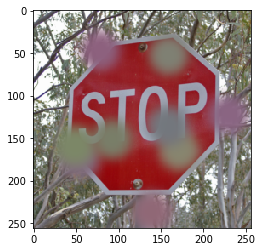

In [146]:
plot_img_from_normalized_img(doted_img.squeeze().detach().numpy())

In [147]:
pred = model(doted_img)
for elem in np.argsort(pred.detach().numpy())[0][-5:]:
    print(idx2label[elem])

barn
chainlink_fence
mailbox
street_sign
birdhouse


# Trial and Errors

In [0]:
xv, yv = torch.meshgrid([torch.arange(0,5), torch.arange(0,10)])

In [0]:
h, w = xv.shape

In [0]:
h, w

(5, 10)

In [0]:
xv

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]])

In [0]:
yv

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])